## CALIBRATION

chessboard found!
chessboard found!
chessboard found!
chessboard found!
chessboard found!
chessboard found!
chessboard found!
chessboard found!
chessboard found!
chessboard found!
chessboard found!
chessboard found!
chessboard found!


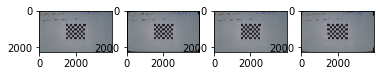

In [1]:
import numpy as np
import cv2
import glob
from tqdm import tqdm
import pandas as pd
import constant as c
import matplotlib.pyplot as plt
# Set the default figure size for all figures
plt.rcParams['figure.figsize'] = (30, 30)  # Adjust the width and height as needed

def calibrate(show=False):
    #chessboard_size = (7, 5)
    chessboard_size = (8, 6)
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((chessboard_size[0]*chessboard_size[1],3), np.float32)
    objp[:,:2] = np.mgrid[0:chessboard_size[0],0:chessboard_size[1]].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    #images = glob.glob('../calibration/small_chessboard_images/*.jpg')
    #images = glob.glob('../calibration/new_chessboard_images/*.jpg')
    images = glob.glob('../calibration/new_chessboard_images/*.jpg')
    
    #images = glob.glob('../calibration/chessboard_images/*.jpg')
    #print(images)
    for fname in images:
        img = cv2.imread(fname)
        dims = img.shape
        height = dims[0]
        width = dims[1]
        channels = dims[2]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to a gray scale image
        #Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

        # If found, add object points, image points (after refining them)
        if ret == True:
            print('chessboard found!')
            objpoints.append(objp)
            corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
            imgpoints.append(corners2)
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, chessboard_size, corners2,ret)
            # cv2.namedWindow('chessboard', cv2.WINDOW_NORMAL)
            # cv2.resizeWindow('chessboard', width,height)
            # cv2.imshow('chessboard',img)
            # cv2.waitKey(0)
        else:
            print('no chessboard found...')
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)


ret, camera_mat, dist_coef, rvecs, tvecs = calibrate()
img = cv2.imread('../calibration/new_chessboard_images/20231024_081900.jpg')
img_und = cv2.undistort(img, camera_mat, dist_coef)
plt.subplot(1,4,1)
plt.imshow(img)
plt.subplot(1,4,2)
plt.imshow(img_und)

new_cammat = cv2.getOptimalNewCameraMatrix(camera_mat, dist_coef, (img.shape[1], img.shape[0]), 1)[0]
map = cv2.initUndistortRectifyMap(camera_mat, dist_coef, np.eye(3), new_cammat, (img.shape[1], img.shape[0]), cv2.CV_32FC1)
img_und = cv2.remap(img, map[0], map[1], cv2.INTER_AREA)
plt.subplot(1,4,3)
plt.imshow(img)
plt.subplot(1,4,4)
plt.imshow(img_und)

## UNWARPING

In [2]:

def unwarp(src, mtx, dist, show=False):
    h,  w = src.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
    # undistort
    dst = cv2.undistort(src, mtx, dist, None, newcameramtx)
    # crop the image
    x,y,w,h = roi
    dst = dst[y:y+h, x:x+w]
    if show:
        cv2.imshow('warped_frame',src)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        cv2.imshow('unwarped_frame',dst)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return dst
frame = cv2.imread('10H-10L/image_group_0_frame_202.0.jpg')
unwarped_frame = unwarp(frame, camera_mat, dist_coef, True)

## MARKERS

In [3]:

import time
import math

    
def getperpcoord(ax, ay, bx, by, startLength, endLength):
    vx = bx-ax
    vx_offset = vx/2.0
    vy = by-ay
    vy_offset = vy/2.0
    #print(str(vx)+" "+str(vy))
   # if(vx == 0 or vy == 0):
   #     return 0, 0, 0, 0
    mag = math.sqrt(vx*vx + vy*vy)
    vx = vx / mag
    vy = vy / mag
    temp = vx
    vx = 0-vy
    vy = temp
    cx = int(bx + (abs(bx-ax)/2.0) + vx * endLength)
    cy = int(by + vy * endLength)

    dx = int(bx + (abs(bx-ax)/2.0)  + vx * startLength) #- vx * length
    dy = int(by + vy * startLength)

    c = (cx, cy) if cy < dy else (dx, dy)
    d = (dx, dy) if dy > cy else (cx, cy)
    return c, d



def getMarkersCenters(src_image):
    dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_100)
    parameters =  cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(dictionary, parameters)
    markersCorners, markerIds, rejectedCandidates = detector.detectMarkers(src_image)
    markersCenters = []
    markerSideMillimeters = 47.0 #mm
    ratioPixelToMillimeters = 0
    ratioMillimetersToPixels = 0
    for markerCorners in markersCorners:
        markerAreaPixels = cv2.contourArea(markerCorners)
        markerSidePixels = math.sqrt(markerAreaPixels)
        ratioPixelToMillimeters += markerSidePixels/markerSideMillimeters
        ratioMillimetersToPixels += markerSideMillimeters/markerSidePixels
        M = cv2.moments(markerCorners)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            markersCenters.append((cx, cy))
    if len(markersCorners):
        ratioPixelToMillimeters /= len(markersCorners)
        ratioMillimetersToPixels /= len(markersCorners)
    return markersCenters, markersCorners

def loopGetMarkersCenters(src_image, nb_markers, show=False):
    #look for markers
    valueWhite = 0
    markersFound = False
    adjusted_image = None #cv2.cvtColor(dst, cv2.COLOR_BGR2HSV)
    markersCenters = []
    ratioPixelToMillimeters = 0
    ratioMillimetersToPixels = 0
    adjusted_src_image = None
    while not markersFound:
        adjusted_src_image = src_image.copy()
        lower_white = np.array([valueWhite,valueWhite,valueWhite])
        upper_white = np.array([255,255,255])
        adjusted_src_mask = cv2.inRange(adjusted_src_image, lower_white, upper_white)
        adjusted_src_image = cv2.bitwise_and(adjusted_src_image,adjusted_src_image, mask=adjusted_src_mask)
        markersCenters, markersCorners = getMarkersCenters(adjusted_src_image)
        markersFound = (len(markersCenters) == nb_markers)
        valueWhite += 1
        if valueWhite > 255:
            return [], 0, 0

    if show:
        print('nbMarkersCenters: %d' %len(markersCenters))
        print('ratioPixelToMillimeters: %f' %ratioPixelToMillimeters)
        print('ratioMillimetersToPixels: %f' %ratioMillimetersToPixels)
        cv2.namedWindow('adjusted_src_image', cv2.WINDOW_NORMAL)
        cv2.resizeWindow('adjusted_src_image', adjusted_src_image.shape[1], adjusted_src_image.shape[0])
        cv2.imshow('adjusted_src_image',adjusted_src_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return markersCenters, markersCorners


# def getLines(src_image, markersCenters, ratioMillimetersToPixels, poleHeight, show=False):
#     processed_src_image = src_image.copy()
#     groundToWoodPlateMillimeters = 20
#     woodToDisplayStartMillimeters = 130
#     DisplayStartToDisplayEndMillimeters = poleHeight #500 true 
#     groundToMarkersMillimeters = 70 #60 true
#     groundToDisplayStartMillimeters = (groundToWoodPlateMillimeters + woodToDisplayStartMillimeters) - groundToMarkersMillimeters
#     groundToDisplayEndMillimeters = groundToDisplayStartMillimeters + DisplayStartToDisplayEndMillimeters
#     groundToDisplayStartPixels = groundToDisplayStartMillimeters * ratioMillimetersToPixels
#     groundToDisplayEndPixels = groundToDisplayEndMillimeters * ratioMillimetersToPixels

#     a = markersCenters[0] if markersCenters[0][0] >  markersCenters[1][0] else markersCenters[1]
#     b = markersCenters[0] if markersCenters[0][0] <  markersCenters[1][0] else markersCenters[1]

#     c, d = getperpcoord(
#         a[0],
#         a[1], 
#         b[0], 
#         b[1], 
#         groundToDisplayStartPixels,
#         groundToDisplayEndPixels,
#         ) 
#     #cv2.circle(processed_src_image, markersCenters[0], 7, (255, 255, 255), 10)
#     #cv2.circle(processed_src_image, markersCenters[1], 7, (255, 255, 255), 10)
#     cv2.line(processed_src_image, markersCenters[0], markersCenters[1], (255, 0, 0),  10)
#     cv2.line(processed_src_image, c, d, (255, 0, 0),  10)
    
#     # alpha = 10 #255/max_red_value # Contrast control
#     # beta = 10 # Brightness control
#     # test_src_image = cv2.convertScaleAbs(processed_src_image, alpha=alpha, beta=beta)
#     # cv2.imshow("test_src_image", test_src_image)
#     # cv2.waitKey(0)
#     if show:
#         cv2.namedWindow('processed_src_image', cv2.WINDOW_NORMAL)
#         cv2.resizeWindow('processed_src_image', processed_src_image.shape[1], processed_src_image.shape[0])
#         cv2.imshow('processed_src_image',processed_src_image)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
#     return processed_src_image, a, b, c, d


def getLines(src_image, nbMarkers, marker_line_mm_length, pole_height, show=False):
    frame = src_image.copy()
    # get left and right point
    NB_MARKERS = 2
    marker_centers, marker_corners = loopGetMarkersCenters(frame, NB_MARKERS)
    
    left_point = np.array(marker_centers[0]) if marker_centers[0][0] >  marker_centers[1][0] else np.array(marker_centers[1])
    right_point = np.array(marker_centers[0]) if marker_centers[0][0] <  marker_centers[1][0] else np.array(marker_centers[1])

    # get upper and lower point

    marker_line_pixel_length = cv2.norm(left_point - right_point)
    ratio_px_to_mm = marker_line_pixel_length/marker_line_mm_length
    ratio_mm_to_px = marker_line_mm_length/marker_line_pixel_length
    ground_to_wood_plate_mm = 20
    wood_to_display_start_mm = 130
    display_start_to_display_end_mm = pole_height #500
    ground_to_markers_mm = 70
    ground_to_display_start_mm = (ground_to_wood_plate_mm + wood_to_display_start_mm) - ground_to_markers_mm
    ground_to_display_end_mm = ground_to_display_start_mm + display_start_to_display_end_mm
    ground_to_display_start_px = ground_to_display_start_mm * ratio_mm_to_px
    ground_to_display_end_px = ground_to_display_end_mm * ratio_mm_to_px


    a, b = getperpcoord(
        left_point[0],
        left_point[1], 
        right_point[0], 
        right_point[1], 
        ground_to_display_start_px,
        ground_to_display_end_px,
    ) 
    
    upper_point = a if a[1] < b[1] else b
    lower_point = b if b[1] > a[1] else a
    
    cv2.line(frame, left_point, right_point, (255, 0, 0),  3)
    cv2.line(frame, lower_point, upper_point, (255, 0, 0),  3)

    return frame, np.asarray(left_point).astype(int), np.asarray(right_point).astype(int), np.asarray(lower_point).astype(int), np.asarray(upper_point).astype(int), ratio_px_to_mm, ratio_mm_to_px

# NB_MARKERS = 2
# markersCenters, ratioPixelToMillimeters, ratioMillimetersToPixels = loopGetMarkersCenters(unwarped_frame, NB_MARKERS, True)
# assert NB_MARKERS == len(markersCenters)
# marked_frame, lowerCenter, upperCenter = getVerticalLine(unwarped_frame,  markersCenters, ratioPixelToMillimeters, show=True)
# print(lowerCenter, upperCenter)

# MERGER

In [66]:
import importlib
import troposkein as tp
from scipy.interpolate import splprep, splev
import constant as c
importlib.reload(c)
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import seaborn as sns
import os

NB_GROUP = len(c.speed_factors) * len(c.strip_factors)

def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)


def angles(u, v): 
  #using the arccos function from numpy
  return np.arccos(u.dot(v)/(np.linalg.norm(u)*np.linalg.norm(v)))


def rotate(src_image, lowerCenter, upperCenter, show=False):
    
    # tupleLowerCenter = tuple(lowerCenter.astype(float))
    # tupleUpperCenter = tuple(upperCenter.astype(float))
    rotated_src_image = src_image.copy()
    d_to_c_error = upperCenter[0] - lowerCenter[0]
    u = np.array([0, upperCenter[1] - lowerCenter[1]])
    v = np.array([d_to_c_error, upperCenter[1] - lowerCenter[1]])
    f_angle = angles(u,v)
    angle = math.degrees(f_angle)
    rotation_matrix = cv2.getRotationMatrix2D(lowerCenter.astype(float), -angle, 1.0)
    #cv2.line(rotated_src_image, lowerCenter, (lowerCenter[0], upperCenter[1]), (255, 255, 255),  5)
    #cv2.line(rotated_src_image, lowerCenter, upperCenter, (255, 255, 255),  5)
    rotated_src_image = cv2.warpAffine(rotated_src_image, rotation_matrix, (rotated_src_image.shape[1], rotated_src_image.shape[0]))
    return rotated_src_image, rotation_matrix


def getMask(src_image, low_down_red, high_down_red, lower_up_red, high_up_red, alpha, beta, morphological_seq, show=False):
    frame = src_image.copy()
    # Split the channels
    b, g, r = cv2.split(frame)
    # r_equalized = cv2.equalizeHist(r)

    # result_image = cv2.merge([b, g, r_equalized])
    # # Display the original and result images
    # cv2.imshow('Increased Contrast on Red Channel', result_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    b[:] = 0
    g[:] = 0
    red_channel_gray = cv2.merge([b, g, r])
    red_channel_gray = cv2.cvtColor(red_channel_gray, cv2.COLOR_BGR2GRAY)

    # cv2.imshow('Before', red_channel_gray)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # _, mask = cv2.threshold(red_channel_gray, 1, 255, cv2.THRESH_BINARY)
    # red_channel_gray = cv2.bitwise_and(red_channel_gray,red_channel_gray,mask=mask)
    # cv2.imshow('Before', mask)
    # cv2.waitKey(0)
    #cv2.destroyAllWindows()
    #clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(3,3))
    #red_channel_gray = clahe.apply(red_channel_gray)
    # cv2.imshow('After', red_channel_gray)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    hist, bins = np.histogram(red_channel_gray.ravel(),256,[0,256])
    # Normalize the array to the range [0, 1]
    #hist = (hist - hist.min()) / (hist.max() - hist.min())
    hist = (hist - hist.mean()) / hist.std()
    # L2 norm
    #norm = np.linalg.norm(hist)  # Calculate the L2 norm of the data
    #hist = hist / norm
    # mask all values with hist < 0.5
    value_to_find = 0.0
    indices = np.where(hist < value_to_find)
    first_index = indices[0][0]
    threshold_value = bins[first_index]
    #print("threshold_value: %d" %threshold_value)
    # print("BEFORE")
    # print(hist)
    # print(bins)
    # sns.barplot(x=bin_edges[:-1], y=hist_values, color='green', alpha=0.7)
    # plt.show()
    _, mask = cv2.threshold(red_channel_gray, threshold_value, 255, cv2.THRESH_BINARY)
    #red_channel_gray = cv2.bitwise_and(red_channel_gray,red_channel_gray,mask=mask)
    # cv2.imshow('After', mask)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    # assert False
    #hist,bins = np.histogram(red_channel_gray.ravel(),256,[0,256])
    # plt.hist(img.ravel(),256,[0,256])
    # plt.show()
    # threshold_value = 100

    #range for red color
    #frame = cv2.convertScaleAbs(frame, alpha=alpha, beta=beta)
    # hsv = cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)
    # mask0 = cv2.inRange(hsv, low_down_red, high_down_red)
    # mask1 = cv2.inRange(hsv, lower_up_red, high_up_red)
    # mask = mask0+mask1
    mask = morph(mask, morphological_seq)

    frame = cv2.bitwise_and(frame,frame,mask=mask)
    cv2.imshow("frame", frame) if show else 0
    cv2.waitKey(0)  if show else 0
    return frame, mask, hist, bins


def filt(src_image, show=False):

    filtered_src_image = src_image.copy()

    # alpha = 2 #255/max_red_value # Contrast control
    # beta = 20 # Brightness control
    # # call convertScaleAbs function
    # filtered_src_image = cv2.convertScaleAbs(filtered_src_image, alpha=alpha, beta=beta)


    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    #range for red color
    hsv = cv2.cvtColor(filtered_src_image,cv2.COLOR_BGR2HSV)
    # lower mask (0-10)
    lower_red = np.array([0,80,80])#np.array([0,50,50])
    upper_red = np.array([10,255,255]) #np.array([10,255,255])
    mask0 = cv2.inRange(hsv, lower_red, upper_red)

    # upper mask (170-180)
    lower_red = np.array([170,80,80]) #np.array([170,50,50])
    upper_red = np.array([180,255,255]) #np.array([180,255,255])
    mask1 = cv2.inRange(hsv, lower_red, upper_red)

    # join my masks
    mask = mask0+mask1
    filtered_src_image = cv2.bitwise_and(filtered_src_image,filtered_src_image,mask=mask)
    # cv2.imshow("masked_src_image", filtered_src_image) if show else 0
    # cv2.waitKey(0)  if show else 0

    # filtered_src_image[:,:, 0] = 0
    # filtered_src_image[:,:, 1] = 0
    # cv2.imshow("redish_src_image", filtered_src_image) if show else 0
    # cv2.waitKey() if show else 0
    # rbin, filtered_src_image = cv2.threshold(filtered_src_image, 44, 255, cv2.THRESH_BINARY)
    # #filtered_src_image = cv2.bitwise_and(filtered_src_image,filtered_src_image,mask=red_mask)
    # cv2.imshow("red_filted_src_image", filtered_src_image) if show else 0
    # cv2.waitKey() if show else 0

    # _,thresh = cv2.threshold(res,0,255,cv2.THRESH_BINARY)
    # # check which are the best canny threshold values for your image
    # imgCanny = cv2.Canny(thresh, 180, 180)
    # dilate = cv2.dilate(imgCanny, None, iterations = 1)
    # cv2.imshow("dilate", dilate)
    # cv2.waitKey()
    NB_ITERATION = 5
    for i in range(NB_ITERATION):
       filtered_src_image = cv2.GaussianBlur(filtered_src_image, (3,3), 0) 
       filtered_src_image = cv2.morphologyEx(filtered_src_image, cv2.MORPH_CLOSE, kernel, 1)
    # cv2.imshow('filtered_src_image',filtered_src_image) if show else 0
    # cv2.waitKey(0) if show else 0
    # cv2.imshow("filtered_src_image", filtered_src_image)
    # cv2.waitKey(0)

    return filtered_src_image



def getFurtherestEdge(src_image, points, direction):
        curvePoints = None

        index_topmost_point = points[:, :, 1].argmin()
        index_bottommost_point = points[:, :, 1].argmax()
        topmost_point = tuple(points[index_topmost_point][0])
        bottommost_point = tuple(points[index_bottommost_point][0])
        first_side_points = None
        second_side_points = None
        diff_index_top_bot_point = index_topmost_point - index_bottommost_point
        if diff_index_top_bot_point > 0:
             first_side_points = points[index_bottommost_point:index_topmost_point+1]
             second_side_points = np.append(points[:index_bottommost_point], points[index_topmost_point+1:], axis=0)
        if diff_index_top_bot_point < 0:
             first_side_points = points[index_topmost_point:index_bottommost_point+1]
             second_side_points = np.append(points[:index_topmost_point], points[index_bottommost_point+1:], axis=0)
        if direction:
            maxFirstSidePoint = 0
            if first_side_points is not None:
                for first_side_index, first_side_point in enumerate(first_side_points):
                    if first_side_points[first_side_index][0][0]  > maxFirstSidePoint:
                        maxFirstSidePoint = first_side_points[first_side_index][0][0]
            maxSecondSidePoint = 0
            if second_side_points is not None:
                for second_side_index, first_side_point in enumerate(second_side_points):
                    if second_side_points[second_side_index][0][0] > maxSecondSidePoint:
                        maxSecondSidePoint = second_side_points[second_side_index][0][0]
            curvePoints = first_side_points if maxFirstSidePoint > maxSecondSidePoint else second_side_points
        else:
            minFirstSidePoint = src_image.shape[1]
            if first_side_points is not None:
                for first_side_index, first_side_point in enumerate(first_side_points):
                    if first_side_points[first_side_index][0][0]  < minFirstSidePoint:
                        minFirstSidePoint = first_side_points[first_side_index][0][0]
            minSecondSidePoint = src_image.shape[1]
            if second_side_points is not None:
                for second_side_index, first_side_point in enumerate(second_side_points):
                    if second_side_points[second_side_index][0][0]  < minSecondSidePoint:
                        minSecondSidePoint = second_side_points[second_side_index][0][0]
            curvePoints = first_side_points if minFirstSidePoint < minSecondSidePoint else second_side_points
        return curvePoints

def curve(src_image, direction = 0, epsilon_smoothing = 0.0, show=False):
    curvePoints = None
    processed_src_image = np.zeros((src_image.shape[0], src_image.shape[1], 3), dtype=np.uint8)
    # mask_image = cv2.inRange(processed_src_image,(0,0,20), (150,255,255))
    # mask_rgb_image = cv2.cvtColor(mask_image, cv2.COLOR_GRAY2BGR)
    # processed_src_image = processed_src_image & mask_rgb_image
    frame = src_image.copy()
    mask = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    biggest_area = -1
    smoothed_biggest = None

    for con in contours:
        area = cv2.contourArea(con)
        if area > 1000 and biggest_area < area:
            biggest_area = area
            biggest = con
            
    if biggest is not None:
        curvePoints = getFurtherestEdge(src_image, biggest, direction)
        convexHullPoints = cv2.convexHull(curvePoints)
        convexHullPoints = getFurtherestEdge(src_image, convexHullPoints, direction)
        old_shape = convexHullPoints.shape
        new_shape = (-1, 2)
        convexHullPoints = convexHullPoints.flatten().reshape(new_shape)
        sorted_indices = np.argsort(convexHullPoints[:, 1])
        convexHullPoints = convexHullPoints[sorted_indices]
        convexHullPoints = convexHullPoints.flatten().reshape(old_shape)

        epsilon = epsilon_smoothing * cv2.arcLength(curvePoints, True)
        smoothedCurvePoints = cv2.approxPolyDP(curvePoints, epsilon, True)
        smoothedCurvePoints = getFurtherestEdge(src_image, smoothedCurvePoints, direction)
        old_shape = smoothedCurvePoints.shape
        new_shape = (-1, 2)
        smoothedCurvePoints = smoothedCurvePoints.flatten().reshape(new_shape)
        sorted_indices = np.argsort(smoothedCurvePoints[:, 1])
        smoothedCurvePoints = smoothedCurvePoints[sorted_indices]
        smoothedCurvePoints = smoothedCurvePoints.flatten().reshape(old_shape)

    return frame, curvePoints, smoothedCurvePoints, convexHullPoints



def morph(src_image, sequence):
    frame = src_image.copy()
    kernel_size = (3,3) #(9, 9)
    kernel =  cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    for i in range(len(sequence)):
        c = sequence[i]
        if c == 'b':
           frame = cv2.GaussianBlur(frame, kernel_size, 0)
        if c == 'o':
           frame = cv2.morphologyEx(frame, cv2.MORPH_OPEN, kernel, 1)
        if c == 'c':
           frame = cv2.morphologyEx(frame, cv2.MORPH_CLOSE, kernel, 1)
    return frame

def merge(H, L, S, N, show=False, save=False):

    pole_height = c.height_values[np.where(c.height_factors == H)[0]]
    rope_length = c.length_values[np.where(c.length_factors == L)[0]]
    angular_speed = S
    strip_index = N
    G = np.where(c.speed_factors == S)[0] * len(c.strip_factors) + strip_index
    regexp_image_names = "%dH-%dL/image_group_%d_frame_*.jpg" %(H, L, G)
    image_names = glob.glob(regexp_image_names)
    image_names = [image_name for image_name in image_names if 'edges' not in image_name]
    masks = []
    frames =  []
    save_path = "../results/figures/H%d-L%d-S%d-N%d" %(H, L, S, N)
    small_save_path = "../results/small-figures/H%d-L%d-S%d-N%d" %(H, L, S, N)

    if save and not os.path.isdir(save_path):
        save_directory = os.mkdir(save_path)

    if save and not os.path.isdir(small_save_path):
        save_directory = os.mkdir(small_save_path)

    # Open the image
    ref_frame = cv2.imread(image_names[0])
    # Undistort the image
    unwarped_ref_frame = unwarp(ref_frame, camera_mat, dist_coef, False)
    # get references points from the image
    
    MARKER_LINE_MM_LENGTH = 358
    DEFAULT_HOLE_RADIUS = c.DEFAULT_HOLE_RADIUS
    _, left_point, right_point, lower_point, upper_point, ratio_px_to_mm, ratio_mm_to_px = getLines(unwarped_ref_frame, 2, MARKER_LINE_MM_LENGTH, pole_height)
    MIN_HOLE_RADIUS_MM = DEFAULT_HOLE_RADIUS * ratio_px_to_mm #c.DEFAULT_HOLE_RADIUS  * ratio_px_to_mm
    MIN_HOLE_RADIUS_PX = int(DEFAULT_HOLE_RADIUS * ratio_mm_to_px) #c.DEFAULT_HOLE_RADIUS  * ratio_mm_to_px
    # display lines
    # offset = 3
    # left_point[0] += offset
    # right_point[0] += offset
    # upper_point[0] += offset
    # lower_point[0] += offset

    # DEBUG REFERENCE FRAME
    # marked_ref_frame = unwarped_ref_frame.copy()
    # alpha = 5
    # beta = 40
    # marked_ref_frame = cv2.convertScaleAbs(marked_ref_frame, alpha=alpha, beta=beta)
    # cv2.line(marked_ref_frame, lower_point, upper_point, (255, 255, 255),  2)
    # cv2.line(marked_ref_frame, left_point, right_point, (255, 255, 255),  2)
    # cv2.circle(marked_ref_frame, upper_point, 2, (255, 0, 0), 6)
    # cv2.circle(marked_ref_frame, lower_point, 2, (0, 0, 255), 6)
    # cv2.circle(marked_ref_frame, np.array(upper_point) + np.array([MIN_HOLE_RADIUS_PX, 0]), 2, (255, 0, 0), 6)
    # cv2.circle(marked_ref_frame, np.array(upper_point) - np.array([MIN_HOLE_RADIUS_PX, 0]), 2, (255, 0, 0), 6)
    # cv2.circle(marked_ref_frame, np.array(lower_point) + np.array([MIN_HOLE_RADIUS_PX, 0]), 2, (255, 0, 0), 6)
    # cv2.circle(marked_ref_frame, np.array(lower_point) - np.array([MIN_HOLE_RADIUS_PX, 0]), 2, (255, 0, 0), 6)

    # cv2.imshow("marked_ref_frame", marked_ref_frame) if show else 0
    # cv2.waitKey(0)  if show else 0
    # cv2.destroyAllWindows() if show else 0

    rotated_ref_frame, rotation_matrix = rotate(unwarped_ref_frame, lower_point, upper_point)
    ref_points = np.row_stack((left_point, right_point, lower_point, upper_point)).astype(np.int32)
    ref_points = np.column_stack((ref_points, np.ones((ref_points.shape[0], 1)))).astype(np.int32)
    rotated_ref_points = np.dot(ref_points, rotation_matrix.T).astype(np.int32)
    rotated_left_point, rotated_right_point, rotated_lower_point, rotated_upper_point = tuple(rotated_ref_points)
    
    # cv2.line(rotated_ref_frame, rotated_lower_point, rotated_upper_point, (255, 255, 255),  4)
    # cv2.line(rotated_ref_frame, rotated_left_point, rotated_right_point, (255, 255, 255),  4)
    # rect_rotated_start_point = np.array(rotated_lower_point).copy()
    # rect_rotated_start_point[0] = rect_rotated_start_point[0]-int(MIN_HOLE_RADIUS_PX)
    # rect_rotated_end_point = np.array(rotated_upper_point).copy()
    # rect_rotated_end_point[0] = rect_rotated_end_point[0]+int(MIN_HOLE_RADIUS_PX)
    # cv2.rectangle(rotated_ref_frame, rect_rotated_start_point, rect_rotated_end_point, (255, 255, 255),  4)
    # cv2.imshow("rotated_ref_frame", rotated_ref_frame) if show else 0
    # cv2.waitKey(0)  if show else 0
    # cv2.destroyAllWindows() if show else 0

    
    # alpha = 2.5 
    # beta = 20
    # rotated_ref_frame = cv2.convertScaleAbs(rotated_ref_frame, alpha=alpha, beta=beta)
    # cv2.line(rotated_ref_frame, rotated_lower_point, rotated_upper_point, (255, 255, 255), 2)
    # cv2.line(rotated_ref_frame, rotated_left_point, rotated_right_point, (255, 255, 255),  2)
    # cv2.circle(rotated_ref_frame, rotated_upper_point, 2, (255, 0, 0), 6)
    # cv2.circle(rotated_ref_frame, rotated_lower_point, 2, (0, 0, 255), 6)
    # cv2.imshow("rotated_ref_frame", rotated_ref_frame) if show else 0
    # cv2.waitKey(0)  if show else 0
    # cv2.destroyAllWindows() if show else 0

    # rotate the imag
    low_down_red = np.array([0,100,20])#np.array([0,50,50])
    high_down_red = np.array([10,255,255]) #np.array([10,255,255])
    lower_up_red = np.array([170,100,20]) #np.array([170,50,50])
    high_up_red = np.array([180,255,255]) #np.array([180,255,255])
    # cond_diff_thres = (H==15 and L==35  and S!=150) or (H==20 and L==35)  or (H==10 and L==25)  or (H==10 and L==30)
    # if cond_diff_thres:
    #     low_down_red = np.array([0,100,20])#np.array([0,50,50])
    #     high_down_red = np.array([10,255,255]) #np.array([10,255,255])
    #     lower_up_red = np.array([170,100,20]) #np.array([170,50,50])
    #     high_up_red = np.array([180,255,255]) #np.array([180,255,255])
        
    #fig, axes = plt.subplots(len(image_names),1, figsize=(30, 30))
    for i, image_name in enumerate(image_names):
        src_image = cv2.imread(image_name)
        unwarped_src_image = unwarp(src_image, camera_mat, dist_coef, False)
        rotated_src_image, _ = rotate(unwarped_src_image, lower_point, upper_point)
        frame, mask, hist_values, bin_edges = getMask(
            rotated_src_image, 
            low_down_red=low_down_red, 
            high_down_red=high_down_red, 
            lower_up_red=lower_up_red, 
            high_up_red=high_up_red, 
            alpha=6,
            beta=5, 
            morphological_seq="ooo")
        # axes[i].bar(bin_edges[:-1], hist_values, width=np.diff(bin_edges), color='blue', alpha=0.7, label='Histogram')
        # axes[i].set_ylim((0, 1))
        # axes[i].set_title(image_name)
        frames.append(frame)
        masks.append(mask)
        colorMask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
        colorFrame = cv2.convertScaleAbs(frame, alpha=5, beta=10)
        colorFrame[np.all(colorMask == [0, 0, 0], axis=-1)] =  [255,255,255]
        # cv2.imshow("colorFrame", colorFrame) if show else 0
        # cv2.waitKey(0)  if show else 0
        # cv2.destroyAllWindows() if show else 0
        if save:
            original_filename = "original_%d.jpg" %(i)
            cv2.imwrite(os.path.join(save_path, original_filename), src_image)
            corrected_filename = "corrected_%d.jpg" %(i)
            cv2.imwrite(os.path.join(save_path, corrected_filename), frame)
            masked_filename = "masked_%d.jpg" %(i)
            cv2.imwrite(os.path.join(save_path, masked_filename), colorMask)


    #plt.show()

    summedMask =  np.array(masks).sum(axis=0).astype(np.uint8)
    summedMask = cv2.cvtColor(summedMask, cv2.COLOR_GRAY2BGR)
    summedFrame =  np.array(frames).sum(axis=0).astype(np.uint8)
    blendedFrame =  (np.array(frames) / len(frames)).sum(axis=0).astype(np.uint8)
    blendedFrame = cv2.convertScaleAbs(blendedFrame, alpha=5, beta=10)
    blendedMask = summedMask
    blendedMask = morph(blendedMask, "bco")
    blendedFrame[np.all(blendedMask == [0, 0, 0], axis=-1)] =  [0,0,0]

    # display(blendedFrame.shape)
    # display(summedMask.shape)
    # print(summedMask == [0, 0, 0])
    maskedBlendedFrame =  blendedFrame.copy()
    maskedBlendedFrame[np.all(blendedMask == [0, 0, 0], axis=-1)] =  [255,255,255]
    reversedMaskedBlendedFrame = blendedFrame.copy()
    reversedMaskedBlendedFrame[np.all(blendedMask == [0, 0, 0], axis=-1)] =  [0,0,0]

    if save:
        joined_filename = "joined_%d.jpg" %(i)
        cv2.imwrite(os.path.join(save_path, joined_filename), summedMask)
        blended_filename = "blended_%d.jpg" %(i)
        cv2.imwrite(os.path.join(save_path, blended_filename), maskedBlendedFrame)

    # blendedMaskedFrame, blendedMask = getMask(blendedFrame, low_down_red=low_down_red, high_down_red=high_down_red, lower_up_red=lower_up_red, high_up_red=high_up_red,  alpha=2.5, beta=5, morphological_seq="", show=False)
    # blendedMask = cv2.cvtColor(blendedMask, cv2.COLOR_GRAY2BGR)
    
    # cv2.imshow("blendedMask", blendedMask) if show else 0
    # cv2.waitKey(0)  if show else 0
    # cv2.destroyAllWindows() if show else 0
    # cv2.line(blendedFrame, rotated_lower_point, rotated_upper_point, (255, 255, 255),  4)
    # cv2.line(blendedFrame, rotated_left_point, rotated_right_point, (255, 255, 255),  4)
    # rect_rotated_start_point = np.array(rotated_lower_point).copy()
    # rect_rotated_start_point[0] = rect_rotated_start_point[0]-int(MIN_HOLE_RADIUS_PX)
    # rect_rotated_end_point = np.array(rotated_upper_point).copy()
    # rect_rotated_end_point[0] = rect_rotated_end_point[0]+int(MIN_HOLE_RADIUS_PX)
    # cv2.rectangle(blendedFrame, rect_rotated_start_point, rect_rotated_end_point, (255, 255, 255),  4)

    # cv2.line(blendedFrame, lower_point, upper_point, (255, 0, 255),  2)
    # cv2.line(blendedFrame, left_point, right_point, (255, 0, 255),  2)
    # rect_start_point = np.array(lower_point).copy()
    # rect_start_point[0] = rect_start_point[0]-int(MIN_HOLE_RADIUS_PX)
    # rect_end_point = np.array(upper_point).copy()
    # rect_end_point[0] = rect_end_point[0]+int(MIN_HOLE_RADIUS_PX)
    # cv2.rectangle(blendedFrame, rect_start_point, rect_end_point, (255, 0, 255),  2)
    # # rotate the image
    # rotatedMask, _ = rotate(summedMask, lower_point, upper_point)
    # crop the image
    filledColor = [0,0,0]
    leftMask = blendedMask[rotated_upper_point[1]:rotated_lower_point[1], 0:rotated_upper_point[0]].copy()  #-int(MIN_HOLE_RADIUS_PX)
    leftMask[::,  leftMask.shape[1]-int(MIN_HOLE_RADIUS_PX):leftMask.shape[1]] = np.array(filledColor)
    leftSumFrame = summedFrame[rotated_upper_point[1]:rotated_lower_point[1], 0:rotated_upper_point[0]].copy()  #-int(MIN_HOLE_RADIUS_PX)
    leftSumFrame[::,  leftSumFrame.shape[1]-int(MIN_HOLE_RADIUS_PX):leftSumFrame.shape[1]] = np.array([0,0,0])
    leftBlendFrame = blendedFrame[rotated_upper_point[1]:rotated_lower_point[1], 0:rotated_upper_point[0]].copy() #-int(MIN_HOLE_RADIUS_PX)
    leftBlendFrame[::,  leftBlendFrame.shape[1]-int(MIN_HOLE_RADIUS_PX):leftBlendFrame.shape[1]] = np.array(filledColor)


    rightMask = blendedMask[rotated_upper_point[1]:rotated_lower_point[1], rotated_upper_point[0]::].copy()  #+int(MIN_HOLE_RADIUS_PX)
    rightMask[::,  0:int(MIN_HOLE_RADIUS_PX)] = np.array(filledColor)
    rightSumFrame = summedFrame[rotated_upper_point[1]:rotated_lower_point[1], rotated_upper_point[0]::].copy() #+int(MIN_HOLE_RADIUS_PX)
    rightSumFrame[::,  0:int(MIN_HOLE_RADIUS_PX)] = np.array(filledColor)
    rightBlendFrame = blendedFrame[rotated_upper_point[1]:rotated_lower_point[1], rotated_upper_point[0]::].copy()  #int(MIN_HOLE_RADIUS_PX)
    rightBlendFrame[::,  0:int(MIN_HOLE_RADIUS_PX)] = np.array(filledColor)
    

    if leftMask.shape[1] > rightMask.shape[1]:
        leftMask = leftMask[::, (leftMask.shape[1] -  rightMask.shape[1])::].copy()
        leftSumFrame = leftSumFrame[::, (leftMask.shape[1] -  rightMask.shape[1])::].copy()
        leftBlendFrame = leftBlendFrame[::, (leftMask.shape[1] -  rightMask.shape[1])::].copy()

    if leftMask.shape[1] < rightMask.shape[1]:
        rightMask = rightMask[::, 0: rightMask.shape[1] - (rightMask.shape[1] -  leftMask.shape[1])].copy()
        rightSumFrame = rightSumFrame[::, 0: rightMask.shape[1] - (rightMask.shape[1] -  leftMask.shape[1])].copy()
        rightBlendFrame = rightBlendFrame[::, 0: rightMask.shape[1] - (rightMask.shape[1] -  leftMask.shape[1])].copy()
    
    leftMaskBlendFrame = leftBlendFrame.copy()
    leftMaskBlendFrame[np.all(leftMask == [0, 0, 0], axis=-1)] =  [255,255,255]

    rightMaskBlendFrame = rightBlendFrame.copy()
    rightMaskBlendFrame[np.all(rightMask == [0, 0, 0], axis=-1)] =  [255,255,255]

    if save:
        cropped_left_filename = "cropped_left_%d.jpg" %(i)
        cv2.imwrite(os.path.join(save_path, cropped_left_filename), leftMask)
        cropped_right_filename = "cropped_right_%d.jpg" %(i)
        cv2.imwrite(os.path.join(save_path, cropped_right_filename), rightMask)
        cropped_blended_left_filename = "cropped_blended_left_%d.jpg" %(i)
        cv2.imwrite(os.path.join(save_path, cropped_blended_left_filename), leftMaskBlendFrame)
        cropped_blended_right_filename = "cropped_blended_right_%d.jpg" %(i)
        cv2.imwrite(os.path.join(save_path, cropped_blended_right_filename), rightMaskBlendFrame)


    EPSILON_SMOOTHING = 0.003
    leftCurveMask, leftCurvePoints, smoothLeftCurvePoints, leftConvexHull = curve(leftMask, direction = 0, epsilon_smoothing=EPSILON_SMOOTHING, show = False)   
    leftCurvePoints = leftCurvePoints.flatten().reshape((-1, 2))
    smoothLeftCurvePoints = smoothLeftCurvePoints.flatten().reshape((-1, 2))
    leftConvexHull = leftConvexHull.flatten().reshape((-1, 2))
    #print(leftCurvePoints.shape, smoothLeftCurvePoints.shape)
    rightCurveMask, rightCurvePoints, smoothRightCurvePoints, rightConvexHull = curve(rightMask, direction = 1, epsilon_smoothing=EPSILON_SMOOTHING, show = False) 
    rightCurvePoints = rightCurvePoints.flatten().reshape((-1, 2))
    smoothRightCurvePoints = smoothRightCurvePoints.flatten().reshape((-1, 2))
    rightConvexHull = rightConvexHull.flatten().reshape((-1, 2))
    #print(rightCurvePoints.shape, smoothRightCurvePoints.shape)

    # compute model
        # MODEL
    hole_radius = c.DEFAULT_HOLE_RADIUS
    pixel_mass = c.DEFAULT_STRIP_MASS
    pixel_pitch = c.DEFAULT_PIXEL_PITCH
    rope_length_offset = c.DEFAULT_TOP_ROPE_LENGTH_OFFSET
    est_curve_x = None
    est_curve_y = None
    adjusted_rope_length = rope_length
    if H==10  and L==10:
        adjusted_rope_length += 0.25 * c.DEFAULT_PIXEL_PITCH
    if H==10  and L==20:
        adjusted_rope_length += 1 * c.DEFAULT_PIXEL_PITCH
    if H==10  and L==25:
        adjusted_rope_length -= 1 * c.DEFAULT_PIXEL_PITCH
    if H==15  and L==15: # LAST
        adjusted_rope_length += 0.5 * c.DEFAULT_PIXEL_PITCH
    if H==15  and L==20:
        adjusted_rope_length += 1.75 * c.DEFAULT_PIXEL_PITCH
    if H==15  and L==25:
        adjusted_rope_length -= 2 * c.DEFAULT_PIXEL_PITCH
    if H==20  and L==25:
        adjusted_rope_length += 0.5 * c.DEFAULT_PIXEL_PITCH
    if H==25  and L==25:
        adjusted_rope_length -= 0.5 * c.DEFAULT_PIXEL_PITCH
    if H==25  and L==30:
        adjusted_rope_length -= 0.5 * c.DEFAULT_PIXEL_PITCH
    if H==25  and L==35:
        adjusted_rope_length -= 1 * c.DEFAULT_PIXEL_PITCH
    est_curve_x, est_curve_y, max_diameter, max_vertical_resolution, max_horizontal_resolution, central_tension, extremity_tension =  tp.troposkein2D(
        angular_speed, 
        adjusted_rope_length, 
        pole_height, 
        hole_radius, 
        pixel_mass, 
        pixel_pitch, 
        rope_length_offset, 
        verbose=False
    )

    target_curve_mm = np.column_stack((est_curve_x, est_curve_y))
    target_curve_px = (target_curve_mm * ratio_mm_to_px).astype(np.int32)

    # OVERLAP CURVES TO BLENDED FRAME (DEBUG SCALING)
    right_debug_curve_px = target_curve_px + rotated_lower_point
    #right_debug_curve_px += np.array([int(MIN_HOLE_RADIUS_PX), 0])
    right_debug_curve_px[:, 1] = (rotated_lower_point[1] - right_debug_curve_px[:, 1]) + rotated_lower_point[1]
    left_debug_curve_px = target_curve_px + rotated_lower_point
    left_debug_curve_px[:, 0] = (rotated_lower_point[0] - left_debug_curve_px[:, 0]) + rotated_lower_point[0]
    left_debug_curve_px[:, 1] = (rotated_lower_point[1] - left_debug_curve_px[:, 1]) + rotated_lower_point[1]
    #left_debug_curve_px -= np.array([int(MIN_HOLE_RADIUS_PX), 0])
    # cv2.line(blendedFrame, rotated_lower_point, rotated_upper_point, (255, 255, 255), 2)
    # cv2.line(blendedFrame, rotated_left_point, rotated_right_point, (255, 255, 255),  2)
    # cv2.circle(blendedFrame, rotated_upper_point, 2, (255, 0, 0), 6)
    # cv2.circle(blendedFrame, rotated_lower_point, 2, (0, 0, 255), 6)
    # cv2.drawContours(blendedFrame, [right_debug_curve_px], -1, (255,255,255), 2)
    # cv2.drawContours(blendedFrame, [left_debug_curve_px], -1, (255,255,255), 2)
    # font 

    # cv2.imshow("blendedFrame", blendedFrame) if show else 0
    # cv2.waitKey(0)  if show else 0
    # cv2.destroyAllWindows() if show else 0


    target_curve_px[:, 1] = rightBlendFrame.shape[0] - target_curve_px[:, 1]

    # overlayed_frame = np.zeros((leftMask.shape[0], leftMask.shape[1], 3), np.uint8)
    # overlayed_frame[:] = (0, 0, 0)

    rightBlendMarkedFrame = rightBlendFrame.copy()
    rightFinalFrame = np.zeros((rightBlendMarkedFrame.shape[0], rightBlendMarkedFrame.shape[1], 3), np.uint8)
    rightFinalFrame[:] = (255, 255, 255)
    # cv2.drawContours(rightBlendMarkedFrame, [target_curve_px], -1, (255,255,255), 3)
    cv2.drawContours(rightBlendMarkedFrame, [rightCurvePoints], -1, (255,255,255), 3)
    # cv2.drawContours(rightBlendMarkedFrame, [smoothRightCurvePoints], -1, (100,255,100), 3)
    # cv2.drawContours(rightBlendMarkedFrame, [rightConvexHull], -1, (0,255,255), 3)

    #cv2.drawContours(rightFinalFrame, [target_curve_px], -1, (0,0,0), 3)
    cv2.drawContours(rightFinalFrame, [rightCurvePoints], -1, (0,0,0), 3)
    # cv2.drawContours(rightFinalFrame, [smoothRightCurvePoints], -1, (100,255,100), 3)
    # cv2.drawContours(rightFinalFrame, [rightConvexHull], -1, (0,255,255), 3)


    leftBlendMarkedFrame = cv2.flip(leftBlendFrame, 1)
    leftFinalFrame = np.zeros((leftBlendMarkedFrame.shape[0], leftBlendMarkedFrame.shape[1], 3), np.uint8)
    leftFinalFrame[:] = (255, 255, 255)
    leftCurvePoints[:, 0] = leftBlendMarkedFrame.shape[1] - leftCurvePoints[:, 0]
    smoothLeftCurvePoints[:, 0] = leftBlendMarkedFrame.shape[1] - smoothLeftCurvePoints[:, 0]
    leftConvexHull[:, 0] = leftBlendMarkedFrame.shape[1] - leftConvexHull[:, 0]

    #cv2.drawContours(leftBlendMarkedFrame, [target_curve_px], -1, (255,255,255), 3)
    cv2.drawContours(leftBlendMarkedFrame, [leftCurvePoints], -1, (255,255,255), 3)
    # cv2.drawContours(leftBlendMarkedFrame, [smoothLeftCurvePoints], -1, (100,255,100), 3)
    # cv2.drawContours(leftBlendMarkedFrame, [leftConvexHull], -1, (0,255,255), 3)

    # cv2.drawContours(leftFinalFrame, [target_curve_px], -1, (0,0,0), 3)
    cv2.drawContours(leftFinalFrame, [leftCurvePoints], -1, (0,0,0), 3)
    # cv2.drawContours(leftFinalFrame, [smoothLeftCurvePoints], -1, (100,255,100), 3)
    # cv2.drawContours(leftFinalFrame, [leftConvexHull], -1, (0,255,255), 3)

    if save:
        extracted_left_filename = "extracted_left_%d.jpg" %(i)
        cv2.imwrite(os.path.join(save_path, extracted_left_filename), leftFinalFrame)
        extracted_right_filename = "extracted_right_%d.jpg" %(i)
        cv2.imwrite(os.path.join(save_path, extracted_right_filename), rightFinalFrame)

    cellWidth = 640
    reducedWidth = 640
    reducedBlendedMask = blendedMask[:, rotated_upper_point[0]-reducedWidth:rotated_upper_point[0]+reducedWidth]
    reducedBlendedFrame = reversedMaskedBlendedFrame[:, rotated_upper_point[0]-reducedWidth:rotated_upper_point[0]+reducedWidth]
    reduced_all_in_one_image = np.concatenate(( 
            ResizeWithAspectRatio(reducedBlendedFrame, width=cellWidth), 
            ResizeWithAspectRatio(reducedBlendedMask, width=cellWidth),
            ), axis=1)
    cv2.putText(reduced_all_in_one_image, 'Strip: %d, Height: %dmm, Length: %dmm, Speed: %drpm' %(strip_index, pole_height, rope_length, angular_speed), (50, 30), cv2.FONT_HERSHEY_SIMPLEX,  1, (255,255,255), 2, cv2.LINE_AA) 
   
    cv2.imshow("reduced_all_in_one_image", reduced_all_in_one_image) if show else 0
    cv2.waitKey(0)  if show else 0
    cv2.destroyAllWindows() if show else 0
    reduced_all_in_one_image_filename = "reduced_all_in_one_image.jpg"
    cv2.imwrite(os.path.join(small_save_path, reduced_all_in_one_image_filename), reduced_all_in_one_image)


    # image_width = cellWidth * 3
    # raw_frames_masks = []
    # for i in range(len(frames)):
    #     raw_frames_masks.append(frames[i])
    #     raw_frames_masks.append(cv2.cvtColor(masks[i], cv2.COLOR_GRAY2BGR))
    # frameWidth = int(image_width/len(raw_frames_masks))
    # print(image_width, frameWidth, len(raw_frames_masks))
    # raw_frames_masks_image  = np.concatenate(tuple([ResizeWithAspectRatio(fm, width=frameWidth) for fm in raw_frames_masks]), axis=1) 
    # halfCellWidth = int(cellWidth/2)
    # first_row_image  = np.concatenate((
    #         ResizeWithAspectRatio(summedMask, width=cellWidth), 
    #         ResizeWithAspectRatio(blendedMask, width=cellWidth), 
    #         ResizeWithAspectRatio(maskedBlendedFrame, width=cellWidth), 
    #         ), axis=1) 
    # second_row_image  = np.concatenate((
    #         ResizeWithAspectRatio(leftBlendFrame, width=halfCellWidth), 
    #         ResizeWithAspectRatio(rightBlendFrame, width=halfCellWidth), 
    #         ResizeWithAspectRatio(leftBlendMarkedFrame, width=halfCellWidth), 
    #         ResizeWithAspectRatio(rightBlendMarkedFrame, width=halfCellWidth), 
    #         ResizeWithAspectRatio(leftFinalFrame, width=halfCellWidth), 
    #         ResizeWithAspectRatio(rightFinalFrame, width=halfCellWidth), 
    #         ), axis=1) 
    # print("first_row_image.shape:", first_row_image.shape)
    # print("second_row_image.shape:", second_row_image.shape)
    # all_in_one_image = np.concatenate((raw_frames_masks_image, first_row_image, second_row_image), axis=0) 
    # cv2.imshow("all_in_one_image", all_in_one_image) if show else 0
    # cv2.waitKey(0)  if show else 0
    # cv2.destroyAllWindows() if show else 0

    target_curve_mm = target_curve_px * ratio_px_to_mm
    left_curve_mm = leftCurvePoints * ratio_px_to_mm
    left_smooth_curve_mm = smoothLeftCurvePoints * ratio_px_to_mm
    left_convex_hull_mm = leftConvexHull * ratio_px_to_mm
    right_curve_mm = rightCurvePoints * ratio_px_to_mm
    right_smooth_curve_mm = smoothRightCurvePoints * ratio_px_to_mm
    right_convex_hull_mm = rightConvexHull * ratio_px_to_mm
    return reduced_all_in_one_image, all_in_one_image, target_curve_mm, left_curve_mm, left_smooth_curve_mm, left_convex_hull_mm, right_curve_mm, right_smooth_curve_mm, right_convex_hull_mm

# reduced_all_in_one_image, all_in_one_image, _, _, _, _, _, _, _ =  merge(H=10, L=10, S=180, N=0, show=True) 
# reduced_all_in_one_image, all_in_one_image, _, _, _, _, _, _, _ =  merge(H=10, L=10, S=330, N=1, show=True) 
# reduced_all_in_one_image, all_in_one_image, _, _, _, _, _, _, _ =  merge(H=10, L=25, S=270, N=0, show=True) 
# reduced_all_in_one_image, all_in_one_image, _, _, _, _, _, _, _  =  merge(H=10, L=35, S=330, N=0, show=True) 
#reduced_all_in_one_image, all_in_one_image, _, _, _, _, _, _, _  =  merge(H=10, L=35, S=150, N=0, show=True) 
#reduced_all_in_one_image, all_in_one_image, _, _, _, _, _, _, _  =  merge(H=10, L=35, S=270, N=3, show=True) 


#reduced_all_in_one_image, all_in_one_image, _, _, _, _, _, _, _  =  merge(H=10, L=35, S=150, N=1, show=True) 
#reduced_all_in_one_image, all_in_one_image, _, _, _, _, _, _, _  =  merge(H=10, L=35, S=150, N=2, show=True) 
#reduced_all_in_one_image, all_in_one_image, _, _, _, _, _, _, _  =  merge(H=10, L=35, S=150, N=3, show=True) 
# reduced_all_in_one_image, all_in_one_image, _, _, _, _, _, _, _ =  merge(H=15, L=35, S=240, N=2, show=True) 

# reduced_all_in_one_image, all_in_one_image, _, _, _, _, _, _, _  =  merge(H=15, L=25, S=300, N=2, show=True) 
# reduced_all_in_one_image, all_in_one_image, _, _, _, _, _, _, _  =  merge(H=20, L=35, S=240, N=0, show=True) 
# reduced_all_in_one_image, all_in_one_image, _, _, _, _, _, _, _  =  merge(H=20, L=20, S=300, N=2, show=True) 
# reduced_all_in_one_image, all_in_one_image, _, _, _, _, _, _, _  =  merge(H=20, L=30, S=210, N=0, show=True) 
# reduced_all_in_one_image, all_in_one_image, _, _, _, _, _, _, _  =  merge(H=20, L=30, S=210, N=1, show=True) 
# reduced_all_in_one_image, all_in_one_image, _, _, _, _, _, _, _  =  merge(H=20, L=30, S=210, N=2, show=True) 
# reduced_all_in_one_image, all_in_one_image, _, _, _, _, _, _, _  =  merge(H=20, L=30, S=210, N=3, show=True) 

#reduced_all_in_one_image, all_in_one_image, _, _, _, _, _, _, _  =  merge(H=15, L=30, S=210, N=1, show=True, save=True) 
reduced_all_in_one_image, all_in_one_image, _, _, _, _, _, _, _  =  merge(H=15, L=30, S=210, N=1, show=True, save=True) 
reduced_all_in_one_image, all_in_one_image, _, _, _, _, _, _, _  =  merge(H=15, L=30, S=240, N=1, show=True, save=True) 
# for speed_index, speed_factor in enumerate(c.speed_factors):
#     reduced_all_in_one_image, all_in_one_image, _, _, _, _, _, _, _  =  merge(H=15, L=30, S=speed_factor, N=1, show=True, save=True) 

#reduced_all_in_one_image, all_in_one_image, _, _, _, _, _, _, _  =  merge(H=10, L=30, S=240, N=1, show=True, save=True) 
#reduced_all_in_one_image, all_in_one_image, _, _, _, _, _, _, _  =  merge(H=10, L=30, S=270, N=1, show=True, save=True) 
# path_img_save = '../results/test0.jpg' 
# cv2.imwrite(path_img_save, reduced_all_in_one_image)
# g = sns.lineplot(y=left_curve_mm[:, 0], x=left_curve_mm[:, 1], color='red')
# g.set(ylim=(0, 500))
# g.set(xlim=(0, 500))
# plt.show()

In [10]:
#https://blog.expertise.dev/2021-06-15-Ship-Position-Estimation-from-Video-Using-OpenCV/
import numpy as np
import cv2
import glob
from tqdm.notebook import tqdm
import pandas as pd
import os
from IPython.display import display
from scipy.interpolate import interp1d


     
#plt.rcParams['figure.figsize'] = [10, 10]
#plt.rcParams["figure.autolayout"] = True
# Shoelace formula
def area(p):
    return np.abs(np.cross(p, np.roll(p, 1, axis=0)).sum()) / 2

def totalLength(points):
    distances = np.linalg.norm(points[1:] - points[:-1], axis=1)
    # Sum up the distances to get the total length
    return distances.sum()



# # Define column names
# columns = ['height', 
#            'length', 
#            'speed', 
#            'strip', 
#            'frame',
#            'mask',
#            ]

# # Create an empty DataFrame with specified column names
# df_features = pd.DataFrame(columns=columns)

# Define column names
columns = [
    'height', 
    'length', 
    'speed', 
    'strip', 
    'group', 
    'result', 
    'orientation',

    'est_xy_curve', 
    'est_x_curve', 
    'est_y_curve', 
    'est_x_width', 
    'est_y_width', 

    'obs_xy_curve', 
    'obs_x_curve',
    'obs_y_curve', 
    'obs_x_width',
    'obs_y_width', 

    'obs_xy_scurve', 
    'obs_x_scurve',
    'obs_y_scurve', 
    'obs_x_swidth',
    'obs_y_swidth', 
    
    'obs_xy_ccurve', 
    'obs_x_ccurve',
    'obs_y_ccurve', 
    'obs_x_cwidth',
    'obs_y_cwidth', 

    'xy_curve_error', 
    'x_width_error', 
    'y_width_error',
    'xy_width_error',
    'est_pitch',
    'est_horizontal_resolution',
    'obs_pitch',
    'pitch_error',
    'pitch_error_rate',
    ]

# Create an empty DataFrame with specified column names
df_trials = pd.DataFrame(columns=columns)



def addTrial(df_trials, pole_height, rope_length, angular_speed, strip_index, group_index, orientation_index, est_curve, obs_curve, obs_scurve, obs_convex):
    est_xy_curve = est_curve
    est_x_curve = est_xy_curve[:, 0]
    est_y_curve = est_xy_curve[:, 1]
    est_x_width = est_xy_curve[np.argmax(est_x_curve), 0]
    est_y_width = est_xy_curve[np.argmax(est_x_curve), 1]

    obs_xy_curve = obs_curve
    obs_x_curve = obs_xy_curve[:, 0]
    obs_y_curve = obs_xy_curve[:, 1]
    obs_x_width = obs_xy_curve[np.argmax(obs_x_curve), 0]
    obs_y_width = obs_xy_curve[np.argmax(obs_x_curve), 1]

    # sns.lineplot(y=obs_x_curve, x=obs_y_curve, color="green")
    # plt.show()

    obs_xy_scurve = obs_scurve
    obs_x_scurve = obs_xy_scurve[:, 0]
    obs_y_scurve = obs_xy_scurve[:, 1]
    obs_x_swidth = obs_xy_scurve[np.argmax(obs_x_scurve), 0]
    obs_y_swidth = obs_xy_scurve[np.argmax(obs_x_scurve), 1]

    
    obs_xy_ccurve = obs_convex
    obs_x_ccurve = obs_xy_ccurve[:, 0]
    obs_y_ccurve = obs_xy_ccurve[:, 1]
    obs_x_cwidth  = obs_xy_ccurve[np.argmax(obs_x_ccurve), 0]
    obs_y_cwidth  = obs_xy_ccurve[np.argmax(obs_x_ccurve), 1]



    interp_observed_func = interp1d(obs_y_curve, obs_x_curve,  fill_value="extrapolate")
    yNewObserved = est_y_curve
    xNewObserved = interp_observed_func(yNewObserved)
    stackPixels = np.column_stack((est_x_curve, est_y_curve))
    stackObserved = np.column_stack((xNewObserved, yNewObserved))
    polygonObserved = np.r_[stackPixels, stackObserved[::-1]]
    # area error
    fillPolygonObservedArea = area(polygonObserved)
    totalLengthObservedCurve = totalLength(stackObserved)
    # ratio area error / length
    xy_curve_error = fillPolygonObservedArea/totalLengthObservedCurve
    x_width_error = est_x_width - obs_x_width
    y_width_error = est_y_width - obs_y_width
    xy_width_error =  totalLength(np.column_stack(([est_x_width, obs_x_width], [est_y_width, obs_y_width])))
    est_pitch = c.DEFAULT_PIXEL_PITCH
    est_horizontal_resolution = (2 * est_x_width  * math.pi) / est_pitch
    obs_pitch =  (2 * obs_x_width * math.pi) / est_horizontal_resolution
    pitch_error = est_pitch - obs_pitch
    pitch_error_rate  =  1 -  obs_pitch / est_pitch

    new_row = pd.DataFrame({
        'height':[pole_height], 
        'length':[rope_length],
        'speed':[angular_speed],
        'strip':[strip_index], 
        'group': [group_index],
        'result': [allImagesName],
        'orientation': [orientation_index],
        'obs_xy_curve': [obs_xy_curve],
        'obs_x_curve': [obs_x_curve],
        'obs_y_curve': [obs_y_curve],
        'obs_x_width': [obs_x_width],
        'obs_y_width': [obs_y_width],

        'obs_xy_scurve': [obs_xy_scurve],
        'obs_x_scurve': [obs_x_scurve],
        'obs_y_scurve': [obs_y_scurve],
        'obs_x_swidth': [obs_x_swidth],
        'obs_y_swidth': [obs_y_swidth],

        'obs_xy_ccurve': [obs_xy_ccurve],
        'obs_x_ccurve': [obs_x_ccurve],
        'obs_y_ccurve': [obs_y_ccurve],
        'obs_x_cwidth': [obs_x_cwidth],
        'obs_y_cwidth': [obs_y_cwidth],

        'est_xy_curve': [est_xy_curve],
        'est_x_curve': [est_x_curve],
        'est_y_curve': [est_y_curve],
        'est_x_width': [est_x_width],
        'est_y_width': [est_y_width],
        'xy_curve_error': [xy_curve_error],
        'x_width_error': [x_width_error],
        'y_width_error': [y_width_error],
        'xy_width_error': [xy_width_error],
        'est_pitch' : [est_pitch],
        'obs_pitch' : [obs_pitch],
        'est_horizontal_resolution' : [est_horizontal_resolution],
        'pitch_error'  : [pitch_error],
        'pitch_error_rate'  : [pitch_error_rate],
    })
    # Add the new row to the DataFrame
    return pd.concat([df_trials, new_row], ignore_index=True)


with tqdm(total=len(c.height_factors) * len(c.length_factors) * len(c.speed_factors) * len(c.strip_factors), desc="Extracting curves from frames", unit="curves") as pbar:
    for height_index, height_factor in enumerate(c.height_factors):
        for length_index, length_factor in enumerate(c.length_factors):
            if length_factor >= height_factor:
                _, _, target_curve_mm, _, _, _, _, _, _ =  merge(H=height_factor, L=length_factor, S=c.speed_factors[0], N=0, show=False) 
                for speed_index, speed_factor in enumerate(c.speed_factors):
                        for strip_index, strip_factor in enumerate(c.strip_factors):
                            poleHeight = c.height_values[height_index]
                            ropeLength = c.length_values[length_index]
                            angularSpeed = c.speed_factors[speed_index]
                            groupIndex = speed_index * len(c.strip_factors) + strip_index
                            _, all_in_one_image, _, left_curve_mm, left_smooth_curve_mm, left_convex_hull_mm, right_curve_mm, right_smooth_curve_mm, right_convex_hull_mm =  merge(H=height_factor, L=length_factor, S=speed_factor, N=strip_index, show=False) 
                            allImagesName = '../results/features/%dH-%dL-%dS-%dG.jpg' %(height_factor, length_factor, speed_factor, strip_factor)
                            if left_curve_mm.size != 0:
                                orientationIndex = 0
                                df_trials = addTrial(df_trials, poleHeight, ropeLength, angularSpeed, strip_index, groupIndex, orientationIndex, target_curve_mm, left_curve_mm, left_smooth_curve_mm, left_convex_hull_mm)
                            if right_curve_mm.size != 0:
                                orientationIndex = 1
                                df_trials = addTrial(df_trials, poleHeight, ropeLength, angularSpeed, strip_index, groupIndex, orientationIndex, target_curve_mm, right_curve_mm, right_smooth_curve_mm, right_convex_hull_mm) 
                            cv2.imwrite(allImagesName, all_in_one_image)
                            pbar.update(1)
df_trials = df_trials.sort_values(by=['height', 'length', 'speed', 'group', 'strip']) 
df_trials.reset_index(drop=True, inplace=True)
df_trials.to_pickle('../results/trials.pkl')

Extracting curves from frames:   0%|          | 0/672 [00:00<?, ?curves/s]

c:\Python38\lib\site-packages\scipy\interpolate\_interpolate.py:698: RuntimeWarning:

divide by zero encountered in true_divide

c:\Python38\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning:

invalid value encountered in reduce

c:\Python38\lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning:

invalid value encountered in multiply

